In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

#Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate  #Additional scklearn functions
from sklearn import metrics
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import cross_val_score
import matplotlib.pylab as plt
smote = SMOTE(sampling_strategy='minority')

In [2]:
train_df = pd.read_csv('train_modified_2.csv')

In [3]:
X = train_df.drop('is_promoted' , axis=1)
y= train_df['is_promoted']

In [4]:
# X_train,X_test, y_train,y_test = \
# train_test_split(X,y,test_size=0.3,random_state=10)

In [5]:
y.sum()/X.shape[0]

0.08517004816815063

In [6]:
y.value_counts()

0.0    50140
1.0     4668
Name: is_promoted, dtype: int64

In [7]:
#pip install --upgrade scikit-learn

In [8]:
#smote.fit_resample

In [9]:
#X_train_smote, y_train_smote = smote.fit_resample(X.astype('float'),y)
X_train_smote, y_train_smote = smote.fit_resample(X,y)

In [10]:
y_train_smote.value_counts()

1.0    50140
0.0    50140
Name: is_promoted, dtype: int64

In [11]:
X_train,X_test, y_train,y_test = \
train_test_split(X_train_smote,y_train_smote,test_size=0.2,random_state=20,stratify=y_train_smote)

In [12]:
y_train.value_counts()

0.0    40112
1.0    40112
Name: is_promoted, dtype: int64

In [13]:
y_test.value_counts()

0.0    10028
1.0    10028
Name: is_promoted, dtype: int64

In [14]:
def modelfit(xgb_model, X_train, y_train,X_test,y_test,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = xgb_model.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=None)
        xgb_model.set_params(n_estimators=cvresult.shape[0])
    
        #Fit the algorithm on the data
        xgb_model.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    xtrain_predictions = xgb_model.predict(X_train)
    xtrain_predprob = xgb_model.predict_proba(X_train)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, xtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, xtrain_predprob))
    
#     Predict on testing data:
    X_test_probability = xgb_model.predict_proba(X_test)[:,1]
    #results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(y_test, X_test_probability))
    
    print(" -------\n \n" )
  
    ## Evaluate accuracy matrix
    # Predict the trading signal on train dataset
    X_train_pred = xgb_model.predict(X_train)
    # Predict the trading signal on test dataset
    X_test_pred = xgb_model.predict(X_test)
    
    ### Training dataset 
    print("Train data Eval")
    print ('Accuracy (train):', accuracy_score(y_train, X_train_pred))
    print ('F1 score (train):', f1_score(y_train, X_train_pred))
    print ('Recall (train):', recall_score(y_train, X_train_pred))
    print ('Precision (train):', precision_score(y_train, X_train_pred))
    
    print(" -------\n \n" )
    
    ### Test dataset 
    print("Test data Eval")
    print ('Accuracy (test):', accuracy_score(y_test, X_test_pred))
    print ('F1 score (test):', f1_score(y_test, X_test_pred))
    print ('Recall (test):', recall_score(y_test, X_test_pred))
    print ('Precision (test):', precision_score(y_test, X_test_pred))
    
    print(" Top Features -------\n \n" ) 
#     plt.figure(figsize=(10,10))
#     feat_imp = pd.Series(xgb_model.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    plt.figure(figsize=(15,8))
    feat_imp = pd.Series(xgb_model.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:15]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.xticks(rotation=45)
    

In [15]:
# plotting cv results
def cv_result():
    
    plt.figure(figsize=(16,6))

    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')

In [16]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


Model Report
Accuracy : 0.9612
AUC Score (Train): 0.994301
AUC Score (Test): 0.989833
 -------
 

Train data Eval
Accuracy (train): 0.9611961507778221
F1 score (train): 0.9606492308081255
Recall (train): 0.9472975668129238
Precision (train): 0.9743826448188322
 -------
 

Test data Eval
Accuracy (test): 0.9522337455125648
F1 score (test): 0.9517137096774193
Recall (test): 0.9414639010769844
Precision (test): 0.9621891561353445
 Top Features -------
 



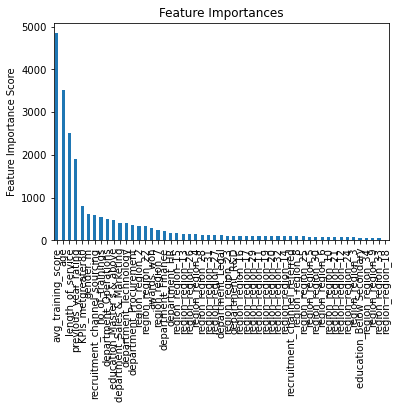

In [17]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1,X_train, y_train,X_test,y_test)

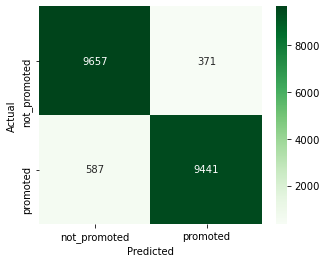

9657 587 9441 371

 clasification report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     10028
         1.0       0.96      0.94      0.95     10028

    accuracy                           0.95     20056
   macro avg       0.95      0.95      0.95     20056
weighted avg       0.95      0.95      0.95     20056


 confussion matrix:
 [[9657  371]
 [ 587 9441]]


In [18]:
# Predict the trading signal on test dataset
X_test_pred = xgb1.predict(X_test)

# Predict the trading signal on test dataset
X_test_pred = xgb1.predict(X_test)
array = confusion_matrix(y_test, X_test_pred)
df = pd.DataFrame(array, index=['not_promoted', 'promoted'], columns=[
'not_promoted', 'promoted'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

TN = array[0,0]
FN = array[1,0]
TP = array[1,1]
FP = array[0,1]
print(TN,FN,TP,FP)


print ('\n clasification report:\n', classification_report(y_test,X_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, X_test_pred))


#### Tunning XGBOOST Parameters 
## Tune max_depth and min_child_weightl

In [27]:
param_test1 = {
 'max_depth':range(2,16,2),
 'min_child_weight':range(1,6,2)
}
print("TUNING ############################")
startgrid=time.time()
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=5,\
                                                  min_child_weight=1, gamma=0, subsample=0.8, \
                                                  colsample_bytree=0.8,objective= 'binary:logistic',\
                                                  nthread=4, scale_pos_weight=1,seed=27),\
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,\
                        cv=5,return_train_score=True)

gsearch1.fit(X_train,y_train)

endgrid = time.time()
print("Grid time: "+str(endgrid-startgrid))

TUNING ############################
[00:17:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Grid time: 1750.6484060287476


In [28]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 14, 'min_child_weight': 1}, 0.9898568801584997)

In [35]:
param_test2 = {
 'max_depth':[19,20,21,22,23,24,25]
}
print("TUNING ############################")
startgrid=time.time()
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120,max_depth=5,\
                                                  min_child_weight=1, gamma=0, subsample=0.4, \
                                                  colsample_bytree=0.4,objective= 'binary:logistic',\
                                                  nthread=4, scale_pos_weight=1,seed=27),\
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,\
                        cv=5,return_train_score=True)

gsearch2.fit(X_train,y_train)

endgrid = time.time()
print("Grid time: "+str(endgrid-startgrid))

TUNING ############################
[01:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Grid time: 656.3776202201843


In [36]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 25}, 0.9898641434667536)

## Step 3: Tune gamma

In [37]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
print("TUNING ############################")
startgrid=time.time()

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=25,\
                                                  min_child_weight=1, gamma=0, subsample=0.8, \
                                                  colsample_bytree=0.8,objective= 'binary:logistic',\
                                                  nthread=4, scale_pos_weight=1,seed=27),\
                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,\
                        cv=5,return_train_score=True)

gsearch3.fit(X_train,y_train)

endgrid = time.time()
print("Grid time: "+str(endgrid-startgrid))

TUNING ############################
[01:31:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Grid time: 1392.4516379833221


In [38]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.9915234298286093)

In [89]:
4:58 5:06
[i/10.0 for i in range(0,5)]

[0.0, 0.1, 0.2, 0.3, 0.4]


Model Report
Accuracy : 0.9986
AUC Score (Train): 0.999960
AUC Score (Test): 0.992470
 -------
 

Train data Eval
Accuracy (train): 0.998603909054647
F1 score (train): 0.9986051609046527
Recall (train): 0.9995013960909453
Precision (train): 0.9977105315548477
 -------
 

Test data Eval
Accuracy (test): 0.9645991224571201
F1 score (test): 0.9643681622001407
Recall (test): 0.9581172716394096
Precision (test): 0.9707011517478279
 Top Features -------
 



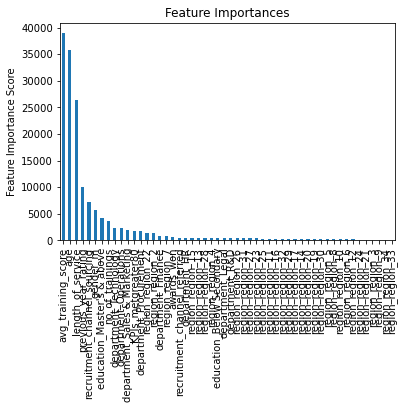

In [39]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=25,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2,X_train, y_train,X_test,y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

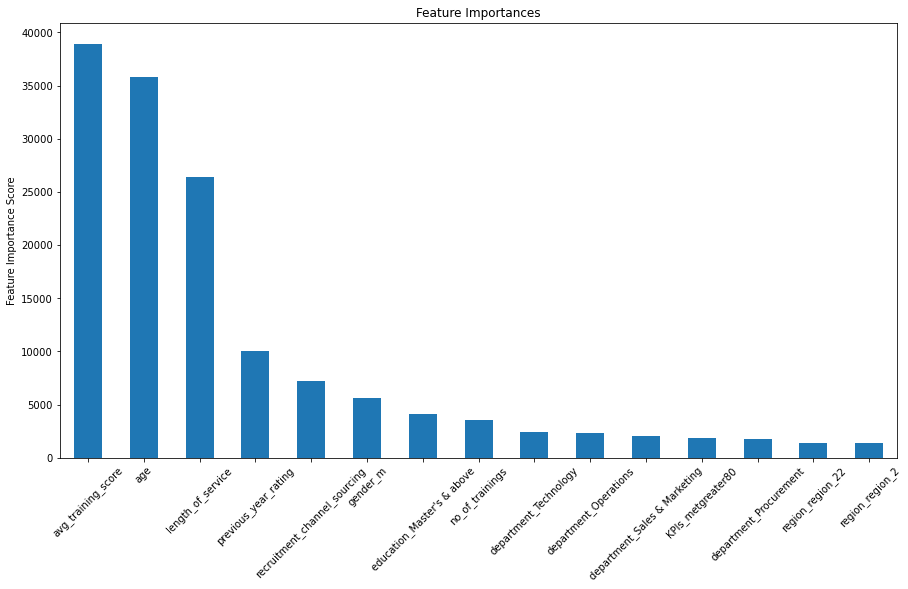

In [52]:
    plt.figure(figsize=(15,8))
    feat_imp = pd.Series(xgb2.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:15]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.xticks(rotation=45)

In [56]:
## Tune subsample & colsample

In [17]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
print("TUNING ############################")
startgrid=time.time()

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=25,\
                                                  min_child_weight=1, gamma=0, subsample=0.8, \
                                                  colsample_bytree=0.8,objective= 'binary:logistic',\
                                                  nthread=4, scale_pos_weight=1,seed=27),\
                        param_grid = param_test4, scoring='roc_auc',n_jobs=4,\
                        cv=5,return_train_score=True)

gsearch4.fit(X_train,y_train)

endgrid = time.time()
print("Grid time: "+str(endgrid-startgrid))

TUNING ############################
[16:41:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Grid time: 3505.567851305008


In [19]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.99158427103715)

In [96]:
[i/10.0 for i in range(6,10)]

[0.6, 0.7, 0.8, 0.9]

In [20]:
param_test5 = {
'reg_alpha':[1e-5,1e-4,1e-3, 1e-2, 0.1, 0.2]
}
print("TUNING ############################")
startgrid=time.time()

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=25,\
                                                  min_child_weight=1, gamma=0, subsample=0.8, \
                                                  colsample_bytree=0.9,objective= 'binary:logistic',\
                                                  nthread=4, scale_pos_weight=1,seed=27),\
                        param_grid = param_test5, scoring='roc_auc',n_jobs=4,\
                        cv=5,return_train_score=True)

gsearch5.fit(X_train,y_train)

endgrid = time.time()
print("Grid time: "+str(endgrid-startgrid))

TUNING ############################
[17:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Grid time: 1363.7894048690796


In [21]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 0.01}, 0.9915134166314197)


Model Report
Accuracy : 0.9991
AUC Score (Train): 0.999982
AUC Score (Test): 0.992522
 -------
 

Train data Eval
Accuracy (train): 0.9990526525727962
F1 score (train): 0.9990533134030892
Recall (train): 0.9997506980454727
Precision (train): 0.9983569010157339
 -------
 

Test data Eval
Accuracy (test): 0.9637514958117271
F1 score (test): 0.9634838515244362
Recall (test): 0.9564220183486238
Precision (test): 0.9706507438518368
 Top Features -------
 



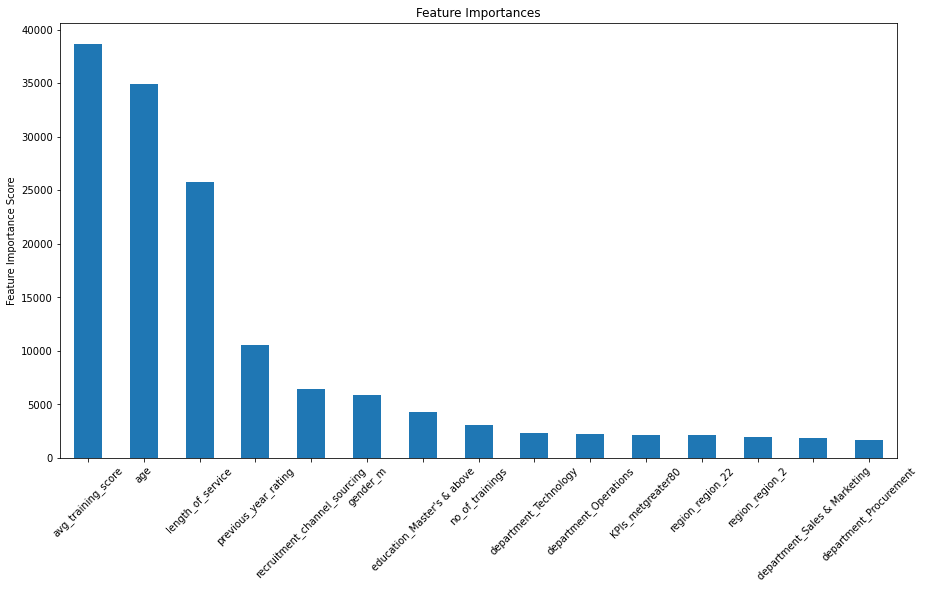

In [22]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=25,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 reg_alpha=.01,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3,X_train, y_train,X_test,y_test)

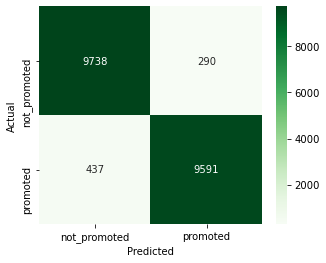

9738 437 9591 290

 clasification report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     10028
         1.0       0.97      0.96      0.96     10028

    accuracy                           0.96     20056
   macro avg       0.96      0.96      0.96     20056
weighted avg       0.96      0.96      0.96     20056


 confussion matrix:
 [[9738  290]
 [ 437 9591]]


In [23]:
# Predict the trading signal on test dataset
X_test_pred = xgb3.predict(X_test)

# Predict the trading signal on test dataset
X_test_pred = xgb3.predict(X_test)
array = confusion_matrix(y_test, X_test_pred)
df = pd.DataFrame(array, index=['not_promoted', 'promoted'], columns=[
'not_promoted', 'promoted'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

TN = array[0,0]
FN = array[1,0]
TP = array[1,1]
FP = array[0,1]
print(TN,FN,TP,FP)


print ('\n clasification report:\n', classification_report(y_test,X_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, X_test_pred))


In [24]:
import pickle

In [25]:
Pkl_Filename = "HR_Smote_XGboostModel_3.pkl" 

In [26]:
import pickle
Pkl_Filename = "HR_Smote_XGboostModel_3.pkl" 

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(xgb3, file)

In [27]:
# # Load the Model back from file
# with open(Pkl_Filename, 'rb') as file:  
#     Pickled_xgb3 = pickle.load(file)

# Pickled_xgb3

In [28]:
mytestdata = pd.read_csv('test_modified_2.csv')
mytestdata.head()
# Predict the trading signal on test dataset
X_test_pred = xgb3.predict(mytestdata)
test = pd.read_csv('test.csv')
test_emp_id = test[['employee_id']]
test_emp_id['is_promoted'] = X_test_pred
test_emp_id['is_promoted'] = test_emp_id['is_promoted'].astype(int)
test_emp_id['is_promoted'].value_counts()
test_emp_id.to_csv('Submission_3.csv',index=False)

In [29]:
mytestdata.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_metgreater80,awards_won,avg_training_score,education_Below Secondary,education_Master's & above,gender_m,...,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9
0,1,24,3.0,1,1,0,77,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,31,3.0,5,0,0,51,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,31,1.0,4,0,0,47,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,31,2.0,9,0,0,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,30,4.0,7,0,0,61,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Predict the trading signal on test dataset
X_test_pred = xgb3.predict(mytestdata)

In [32]:
type(X_test_pred)


numpy.ndarray

In [33]:
test = pd.read_csv('test.csv')
test_emp_id = test[['employee_id']]
test_emp_id

,employee_id
0,8724
1,74430
2,72255
3,38562
4,64486
...,...
23485,53478
23486,25600
23487,45409
23488,1186


In [34]:
test_emp_id['is_promoted'] = X_test_pred
test_emp_id['is_promoted'] = test_emp_id['is_promoted'].astype(int)

In [35]:
test_emp_id['is_promoted'] = X_test_pred
test_emp_id['is_promoted'] = test_emp_id['is_promoted'].astype(int)
test_emp_id['is_promoted'].value_counts()
test_emp_id.to_csv('Submission_3.csv',index=False)

0    22082
1     1408
Name: is_promoted, dtype: int64

In [36]:
test_emp_id.to_csv('Submission_3.csv',index=False)

In [113]:
# Predict the trading signal on test dataset
#X_test_pred = xgb3.predict(mytestdata)

# Predict the trading signal on test dataset
#X_test_pred = xgb3.predict(mytestdata)
array = confusion_matrix(y_test, X_test_pred)
df = pd.DataFrame(array, index=['not_promoted', 'promoted'], columns=[
'not_promoted', 'promoted'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

TN = array[0,0]
FN = array[1,0]
TP = array[1,1]
FP = array[0,1]
print(TN,FN,TP,FP)


print ('\n clasification report:\n', classification_report(y_test,X_test_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, X_test_pred))